In [1]:
%tensorflow_version 1.14
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import keras
keras.__version__

!pip install numpy==1.16.1
import numpy as np

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


Using TensorFlow backend.


     |████████████████████████████████| 17.3MB 199kB/s 
ERROR: tensorflow 1.15.2 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.2
    Uninstalling numpy-1.18.2:
      Successfully uninstalled numpy-1.18.2


# MSIS579 Lab4: Recurrent Neural Networks to Movie Review Sentiment Analysis

Another popular and powerful way to associate a vector with a word is the use of dense "word vectors", also called "word embeddings". 
While the vectors obtained through one-hot encoding are binary, sparse (mostly made of zeros) and very high-dimensional (same dimensionality as the 
number of words in the vocabulary), "word embeddings" are low-dimensional floating point vectors 
(i.e. "dense" vectors, as opposed to sparse vectors). 
Unlike word vectors obtained via one-hot encoding, word embeddings are learned from data. 
It is common to see word embeddings that are 256-dimensional, 512-dimensional, or 1024-dimensional when dealing with very large vocabularies. 
On the other hand, one-hot encoding words generally leads to vectors that are 20,000-dimensional or higher (capturing a vocabulary of 20,000 
token in this case). So, word embeddings pack more information into far fewer dimensions. 

<img src="https://s3.amazonaws.com/book.keras.io/img/ch6/word_embeddings.png" alt="word embeddings vs. one hot encoding" width="400"/>


We can learn the word embeddings jointly with the main task you care about (e.g. document classification or sentiment prediction). In this setup, you would start with random word vectors, then learn your word vectors in the same way that you learn the weights of a neural network.

## Learning word embeddings with the `Embedding` layer


The simplest way to associate a dense vector to a word would be to pick the vector at random. The problem with this approach is that the 
resulting embedding space would have no structure: for instance, the words "accurate" and "exact" may end up with completely different 
embeddings, even though they are interchangeable in most sentences. It would be very difficult for a deep neural network to make sense of 
such a noisy, unstructured embedding space. 

To get a bit more abstract: the geometric relationships between word vectors should reflect the semantic relationships between these words. 
Word embeddings are meant to map human language into a geometric space. For instance, in a reasonable embedding space, we would expect 
synonyms to be embedded into similar word vectors, and in general we would expect the geometric distance (e.g. L2 distance) between any two 
word vectors to relate to the semantic distance of the associated words (words meaning very different things would be embedded to points 
far away from each other, while related words would be closer). Even beyond mere distance, we may want specific __directions__ in the 
embedding space to be meaningful. 


In real-world word embedding spaces, common examples of meaningful geometric transformations are "gender vectors" and "plural vector". For 
instance, by adding a "female vector" to the vector "king", one obtain the vector "queen". By adding a "plural vector", one obtain "kings". 
Word embedding spaces typically feature thousands of such interpretable and potentially useful vectors.

Is there some "ideal" word embedding space that would perfectly map human language and could be used for any natural language processing 
task? Possibly, but in any case, we have yet to compute anything of the sort. Also, there isn't such a thing as "human language", there are 
many different languages and they are not isomorphic, as a language is the reflection of a specific culture and a specific context. But more 
pragmatically, what makes a good word embedding space depends heavily on your task: the perfect word embedding space for an 
English-language movie review sentiment analysis model may look very different from the perfect embedding space for an English-language 
legal document classification model, because the importance of certain semantic relationships varies from task to task.

It is thus reasonable to __learn__ a new embedding space with every new task. Thankfully, backpropagation makes this really easy, and Keras makes it 
even easier. It's just about learning the weights of a layer: the `Embedding` layer.

In [0]:
from keras.layers import Embedding

# The Embedding layer takes at least two arguments:
# the number of possible tokens, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 64.
embedding_layer = Embedding(1000, 64)


The `Embedding` layer is best understood as a dictionary mapping integer indices (which stand for specific words) to dense vectors. It takes 
as input integers, it looks up these integers into an internal dictionary, and it returns the associated vectors. It's effectively a dictionary lookup.


The `Embedding` layer takes as input a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of 
integers. It can embed sequences of variable lengths, so for instance we could feed into our embedding layer above batches that could have 
shapes `(32, 10)` (batch of 32 sequences of length 10) or `(64, 15)` (batch of 64 sequences of length 15). All sequences in a batch must 
have the same length, though (since we need to pack them into a single tensor), so sequences that are shorter than others should be padded 
with zeros, and sequences that are longer should be truncated.

This layer returns a 3D floating point tensor, of shape `(samples, sequence_length, embedding_dimensionality)`. Such a 3D tensor can then 
be processed by a RNN layer or a 1D convolution layer (both will be introduced in the next sections).

When you instantiate an `Embedding` layer, its weights (its internal dictionary of token vectors) are initially random, just like with any 
other layer. During training, these word vectors will be gradually adjusted via backpropagation, structuring the space into something that the 
downstream model can exploit. Once fully trained, your embedding space will show a lot of structure -- a kind of structure specialized for 
the specific problem you were training your model for.

Let's apply this idea to the IMDB movie review sentiment prediction task that you are already familiar with. Let's quickly prepare 
the data. We will restrict the movie reviews to the top 10,000 most common words (like we did the first time we worked with this dataset), 
and cut the reviews after only 20 words. Our network will simply learn 8-dimensional embeddings for each of the 10,000 words, turn the 
input integer sequences (2D integer tensor) into embedded sequences (3D float tensor), flatten the tensor to 2D, and train a single `Dense` 
layer on top for classification.

In [3]:
from keras.datasets import imdb
from keras import preprocessing

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 20

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

17465344/17464789 [==============================] - 1s 0us/step


In [4]:
# Convert encoded review to words
INDEX_FROM=3   # word index offset

word_to_id = keras.datasets.imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id['<PAD>'] = 0
word_to_id['<START>'] = 1
word_to_id['<UNK>'] = 2

id_to_word = {value:key for key,value in word_to_id.items()}
print(' '.join(id_to_word[id] for id in x_train[0] ))

1646592/1641221 [==============================] - 0s 0us/step
story was so lovely because it was true and was someone's life after all that was shared with us all


In [5]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(
    x_train, 
    y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 4s 179us/step - loss: 0.6645 - acc: 0.6323 - val_loss: 0.6081 - val_acc: 0.6962
Epoch 2/10
20000/20000 [==============================] - 2s 89us/step - loss: 0.5323 - acc: 0.7538 - val_loss: 0.5206 - val_acc: 0.7328
Epoch 3/10
20000/20000 [==============================] 

We get to a validation accuracy of ~76%, which is pretty good considering that we only look at the first 20 words in every review. But 
note that merely flattening the embedded sequences and training a single `Dense` layer on top leads to a model that treats each word in the 
input sequence separately, without considering inter-word relationships and structure sentence (e.g. it would likely treat both _"this movie 
is shit"_ and _"this movie is the shit"_ as being negative "reviews"). It would be much better to add recurrent layers or 1D convolutional 
layers on top of the embedded sequences to learn features that take into account each sequence as a whole. That's what we will focus on in 
the next few sections.

## Recurrent Neural Networks



In Keras, RNN can be invoked by the API `SimpleRNN`, which takes inputs of shape `(batch_size, timesteps, input_features)`.

Like all recurrent layers in Keras, `SimpleRNN` can be run in two different modes: it can return either the full sequences of successive 
outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`), or it can return only the last output for each 
input sequence (a 2D tensor of shape `(batch_size, output_features)`). These two modes are controlled by the `return_sequences` constructor 
argument.

In [6]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [7]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


It is sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. 
In such a setup, you have to get all intermediate layers to return full sequences:

In [8]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # This last layer only returns the last outputs.
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Now let's try to use such a model on the IMDB movie review classification problem. First, let's preprocess the data:

In [9]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


Let's train a simple recurrent network using an `Embedding` layer and a `SimpleRNN` layer:

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(
    input_train, 
    y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2
)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 25s 1ms/step - loss: 0.5911 - acc: 0.6757 - val_loss: 0.4344 - val_acc: 0.8176
Epoch 2/10
20000/20000 [==============================] - 25s 1ms/step - loss: 0.3764 - acc: 0.8456 - val_loss: 0.4574 - val_acc: 0.7804
Epoch 3/10
20000/20000 [==============================] - 25s 1ms/step - loss: 0.3464 - acc: 0.8692 - val_loss: 0.3669 - val_acc: 0.8524
Epoch 4/10
20000/20000 [==============================] - 25s 1ms/step - loss: 0.2179 - acc: 0.9195 - val_loss: 0.3503 - val_acc: 0.8698
Epoch 5/10
20000/20000 [==============================] - 25s 1ms/step - loss: 0.1682 - acc: 0.9393 - val_loss: 0.4046 - val_acc: 0.8524
Epoch 6/10
20000/20000 [==============================] - 25s 1ms/step - loss: 0.1182 - acc: 0.9592 - val_loss: 0.3894 - val_acc: 0.8664
Epoch 7/10
20000/20000 [==============================] - 25s 1ms/step - loss: 0.0858 - acc: 0.9714 - val_loss: 0.5449 - val_acc:

Let's display the training and validation loss and accuracy:

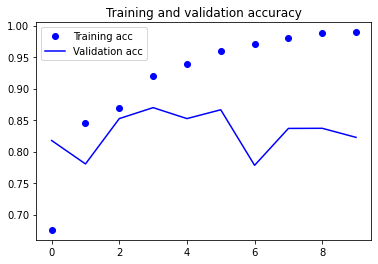

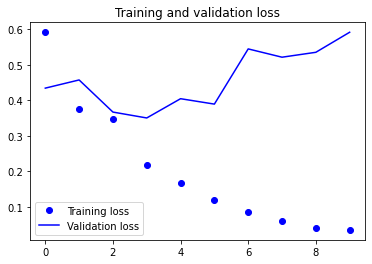

In [11]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Our small recurrent network does better than the 1-layer NN with a 85% validation accuracy. Part of the problem is that `SimpleRNN` isn't very good at processing long sequences, like text. Other types of recurrent layers perform much better. Let's take a look at some 
more advanced layers.

## Long short-term memory (LSTM)

Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in the field of deep learning.

Now let's switch to more practical concerns: we will set up a model using a LSTM layer and train it on the IMDB data. Here's the network, similar to the one with `SimpleRNN` that we just presented. We only specify the output dimensionality of the LSTM layer, and leave every 
other argument (there are lots) to the Keras defaults. Keras has good defaults, and things will almost always "just work" without you having to spend time tuning parameters by hand.

In [12]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc']
)

history = model.fit(
    input_train, 
    y_train,
    epochs=5,
    batch_size=128,
    validation_split=0.2
)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 53s 3ms/step - loss: 0.4994 - acc: 0.7601 - val_loss: 0.3454 - val_acc: 0.8634
Epoch 2/5
20000/20000 [==============================] - 53s 3ms/step - loss: 0.3025 - acc: 0.8844 - val_loss: 0.3120 - val_acc: 0.8718
Epoch 3/5
20000/20000 [==============================] - 52s 3ms/step - loss: 0.2325 - acc: 0.9119 - val_loss: 0.2913 - val_acc: 0.8872
Epoch 4/5
20000/20000 [==============================] - 52s 3ms/step - loss: 0.2019 - acc: 0.9258 - val_loss: 0.3046 - val_acc: 0.8840
Epoch 5/5
20000/20000 [==============================] - 53s 3ms/step - loss: 0.1801 - acc: 0.9370 - val_loss: 0.2889 - val_acc: 0.8866


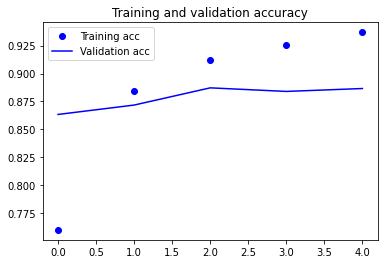

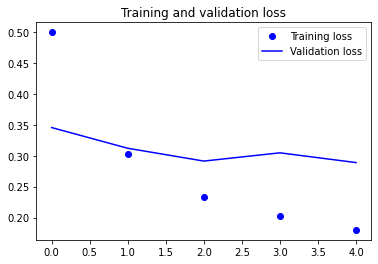

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Extract the word embedding from RNN

Finally, let's take a look at the word embedding learnt from the IMDB movie review dataset. 


In [14]:
from sklearn.metrics.pairwise import cosine_similarity

# access the embedding layer through the constructed model 
# first `0` refers to the position of embedding layer in the `model`
# `embeddings` has a shape of (num_vocab, embedding_dim) 
embeddings = model.layers[0].get_weights()[0]

# `word_to_index` is a mapping (i.e. dict) from words to their index, e.g. `love`: 69
words_embeddings = {w:embeddings[idx] for w, idx in word_to_id.items() if idx < 10000}

# now you can use it like this for example
print(words_embeddings['great'])
print(words_embeddings['good'])
print(words_embeddings['bad'])

print("Similarity between good and great: " + str(cosine_similarity([words_embeddings['good'], words_embeddings['great']])[0,1]))
print("Similarity between good and bad: " + str(cosine_similarity([words_embeddings['good'], words_embeddings['bad']])[0,1]))

[-0.04472766 -0.02760208 -0.07055061  0.04462938 -0.02395611 -0.08736295
 -0.1275043   0.08145905  0.09900965 -0.09810715  0.07465366 -0.06120626
 -0.0597792   0.10772214 -0.05248285 -0.04623779  0.10775667 -0.01321748
 -0.11196747  0.05721187 -0.03814832  0.12067841  0.07312531  0.08846532
 -0.05037005 -0.11035732  0.09495511 -0.13131428 -0.02110894 -0.05348805
 -0.08238757  0.1095679 ]
[ 0.01897926 -0.02800953 -0.02448323  0.06134038 -0.06991422 -0.02126027
 -0.05419149  0.05253145  0.02767433 -0.00279542  0.06654816 -0.04110417
  0.00233827  0.03589464 -0.02610446  0.01929716  0.05021757 -0.05327055
 -0.00881383  0.00316175 -0.04375747  0.02121578 -0.02230714  0.05084708
 -0.03838453 -0.02762152  0.06596976 -0.03933816  0.01908743 -0.07072256
 -0.00075357  0.06256144]
[ 0.07722294  0.12185067  0.1213254  -0.04749038  0.05476239  0.09629762
  0.08360077 -0.07494857 -0.11079032  0.0595921  -0.08747908  0.07556745
  0.03648726 -0.1251197   0.06224074  0.10903712  0.04759882  0.12300456

# End of Lab4